In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.cm as cm
from tqdm import tqdm

In [9]:
cv = True

n_cv = 5

In [10]:
# Cargar los datos
data_path = 'data/cv/'

df_all = pd.read_csv('data/data_shadows_mean_days.csv')
df_train_all_cv, df_test_all_cv = [], []

if cv:
    for i in range(1,n_cv+1):
        df_train_all_cv.append(pd.read_csv(data_path + 'data_train_shadows_mean_days_cv' + str(i) + '.csv'))
        df_test_all_cv.append(pd.read_csv(data_path + 'data_test_shadows_mean_days_cv' + str(i) + '.csv'))
else:
    df_train_all_cv.append(pd.read_csv(data_path + 'data_train_shadows_mean_days_cv1.csv'))
    df_test_all_cv.append(pd.read_csv(data_path + 'data_test_shadows_mean_days_cv1.csv'))

print(len(df_train_all_cv))

print('Total samples =', len(df_train_all_cv[0]) + len(df_test_all_cv[0]))
print('Samples train =', len(df_train_all_cv[0]))
print('Samples test =', len(df_test_all_cv[0]))

5
Total samples = 6907
Samples train = 5538
Samples test = 1369


In [11]:
'''
Functions for the decision tree
'''

def float_to_time(float_time):
    hours = int(float_time)
    minutes = int((float_time - hours) * 60)
    seconds = int((((float_time - hours) * 60) - minutes) * 60)
    return f'{hours:02}:{minutes:02}:{seconds:02}'

def plot_custom_tree(regressor, feature_names):
    fig = plt.figure(figsize=(20, 12))  # Ajustar tamaño de la figura

    n_nodes = regressor.tree_.node_count
    children_left = regressor.tree_.children_left
    children_right = regressor.tree_.children_right
    feature = regressor.tree_.feature
    threshold = regressor.tree_.threshold
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # (node_id, depth)

    total_samples = regressor.tree_.n_node_samples[0]

    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    annotations = []
    colors = []

    for i in range(n_nodes):
        shadow_value = regressor.tree_.value[i][0][0]
        node_samples = regressor.tree_.n_node_samples[i]
        sample_percentage = node_samples / total_samples * 100
        colors.append(shadow_value)

        if is_leaves[i]:
            annotations.append(f'{shadow_value:.2f}\n{sample_percentage:.1f}%')
        else:
            if feature_names[feature[i]] == 'time':
                annotations.append(f'{feature_names[feature[i]]} <= {float_to_time(threshold[i])}')
            else:
                annotations.append(f'{feature_names[feature[i]]} <= {threshold[i]:.2f}')

    _ = plot_tree(regressor, 
                  feature_names=feature_names,  
                  filled=True,
                  rounded=True,
                  node_ids=False,
                  impurity=False,
                  proportion=False,
                  fontsize=22)

    cmap = cm.get_cmap('Blues')
    for i, annotation in enumerate(annotations):
        node = plt.gca().get_children()[i]
        node.set_text(annotation.split('\\n')[0])
        color = cmap(colors[i] / max(colors))
        node.get_bbox_patch().set_facecolor(color)

    plt.savefig('figures/tree.png')
    plt.show()

In [12]:
'''
DECISION TREE
'''

features_tree = ['thi', 'accum_thi', 'mean_THI_night', 'time_float']
#features_tree = ['thi', 'accum_thi', 'time_float']

models = []

for df_train_all, df_test_all in zip(df_train_all_cv, df_test_all_cv):

    df_train_tree = df_train_all.copy()
    df_test_tree = df_test_all.copy()
    df_train_tree = df_train_tree.dropna(subset=['mean_THI_night'])
    df_test_tree = df_test_tree.dropna(subset=['mean_THI_night'])

    X_train = df_train_tree[features_tree]
    X_test = df_test_tree[features_tree]
    y_train = df_train_tree['shadow']
    y_test = df_test_tree['shadow']

    X_train = X_train.rename(columns={
        'thi': 'THI',
        'accum_thi': 'THI accum',
        'mean_THI_night': 'THI night',
        'time_float': 'time'
    })

    X_test = X_test.rename(columns={
        'thi': 'THI',
        'accum_thi': 'THI accum',
        'mean_THI_night': 'THI night',
        'time_float': 'time'
    })

    # Entrenar el modelo
    regressor = DecisionTreeRegressor(criterion='squared_error', max_depth=3, random_state=0, splitter='best')

    regressor.fit(X_train, y_train)

    models.append([X_test, y_test, regressor])

In [13]:
'''
Errors tree
'''

rmse_tree_cv = []
mae_tree_cv = []
# Evaluación del modelo
for model in models:
    X_test, y_test, regressor = model

    y_pred = regressor.predict(X_test)

    rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_tree = mean_absolute_error(y_test, y_pred)

    rmse_tree_cv.append(rmse_tree)
    mae_tree_cv.append(mae_tree)

if cv:
    print(f"RMSE cv: {np.mean(rmse_tree_cv)}")
    print(f"MAE cv: {np.mean(mae_tree_cv)}")
    print('\n')
else:
    print(f"RMSE: {rmse_tree_cv[0]}")
    print(f"MAE: {mae_tree_cv[0]}")

RMSE cv: 16.689339882938413
MAE cv: 13.05841583551271




/tmp/ipykernel_2821609/3609980626.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


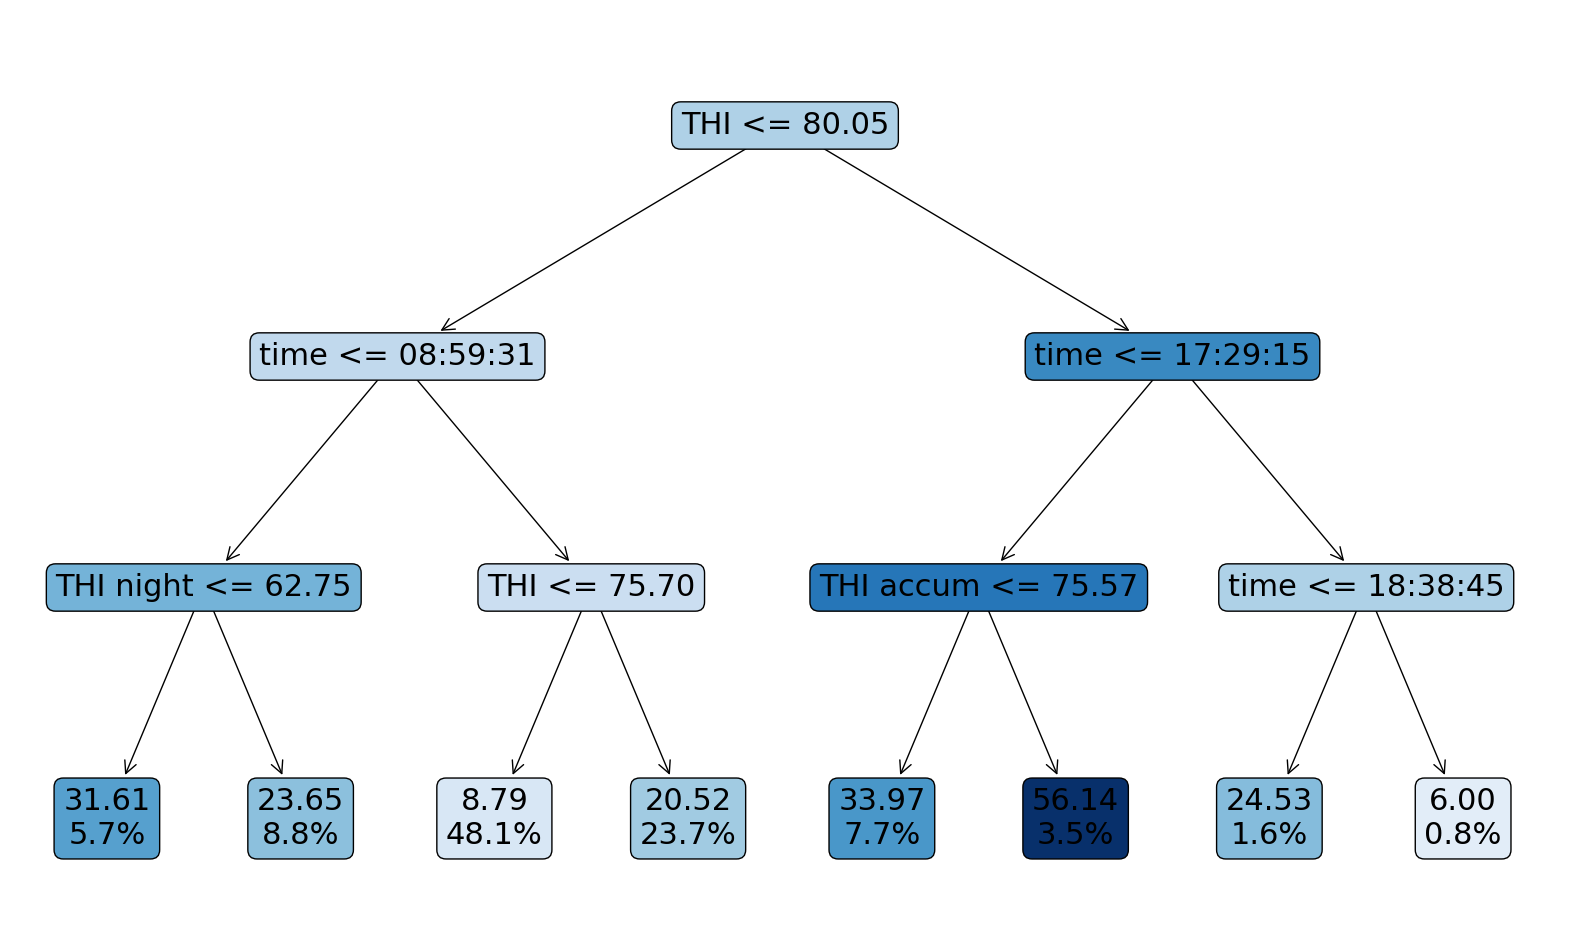

In [14]:
X_test, y_test, regressor = models[0]
plot_custom_tree(regressor, feature_names=list(X_test.columns))

In [15]:
'''
RANDOM FOREST
'''

from sklearn.ensemble import RandomForestRegressor

# from config.config_nn_3 import *
from utils.plots import plot_result, plot_result_v2, plot_result_v3, plot_means

model_name  = 'model_3'

input_vars  = ['time_float',
               'thi',
               'accum_thi',
               'mean_THI_night']
output_vars = ['shadow']

In [17]:
'''
HYPERPARAMETERS ERRORS
'''
'''
print(f'Train Random Forest as model {model_name}.')

trees = [1,2,3,5,7,10,20,30,50,70,100,150,200,300,500,1000]
depth = [1,2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50,60,80,90,100]

trainings = pd.DataFrame(
    [[t, d, cvs, -1.] for t in trees for d in depth for cvs in range(n_cv)],
    columns = ['trees', 'depth', 'cv', 'rmse']
)

for e in tqdm(range(len(trainings))):
    
    df_train = df_train_all_cv[trainings['cv'][e]].copy()
    df_test  = df_test_all_cv[trainings['cv'][e]].copy()

    model = RandomForestRegressor(
        n_estimators        = trainings['trees'][e],
        min_samples_split   = 2,
        min_samples_leaf    = 1,
        max_features        = 3,
        random_state        = 314,
        max_depth           = trainings['depth'][e]
    )

    model.fit(
        df_train[input_vars].values,
        df_train[output_vars].values[:,0]
    )

    predictions = model.predict(
        df_test[input_vars].values
    )

    targets = df_test[output_vars].values[:,0]
    rmse = ((predictions - targets)**2).mean() ** 0.5
    trainings.loc[e, 'rmse'] = rmse
    
    del model

trainings.to_pickle('results/trainings.pkl')
'''

Train Random Forest as model model_3.


100%|██████████| 1680/1680 [29:28<00:00,  1.05s/it]


In [18]:
'''
LOAD trainings
'''

trainings = pd.read_pickle('results/trainings.pkl')

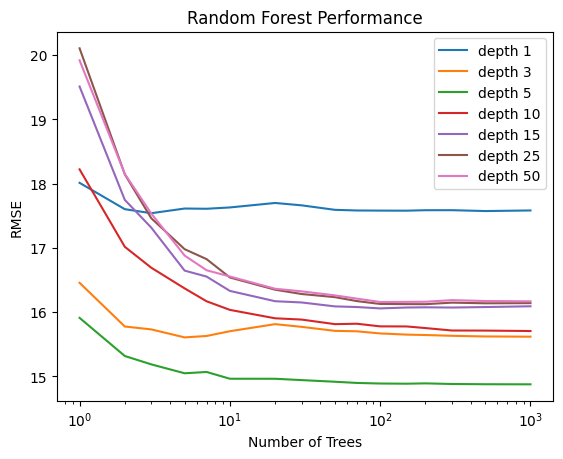

In [19]:
'''
HYPERPARAMETERS ERRORS PLOTS
'''

depth = [1,3,5,10,15,25,50]

trainings_cv = trainings.copy()
trainings_cv = trainings_cv.drop(columns=['cv'])
if cv:
    trainings_cv = trainings_cv.groupby(['trees', 'depth']).agg({'rmse': 'mean'}).reset_index()

trainings_cv.to_csv('trainings_cv.csv', index=False)


plt.figure()
for d in depth:
    plt.plot(trainings_cv[trainings_cv['depth'] == d]['trees'], trainings_cv[trainings_cv['depth'] == d]['rmse'], label = f'depth {d}')
plt.xscale('log')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.legend()
if cv:
    plt.title('Random Forest Performance')
    plt.savefig('figures/rmse_RF_' + str(n_cv) + 'cv.png')
else:
    plt.title('Random Forest Performance')
    plt.savefig('figures/rmse_RF.png')
plt.show()

100%|██████████| 35/35 [00:00<00:00, 71.18it/s] 


   depth       rmse
0      1  17.993725
1      3  16.689340
2      5  16.026434
3     10  18.727124
4     15  19.907496
5     25  20.188367
6     50  20.185699


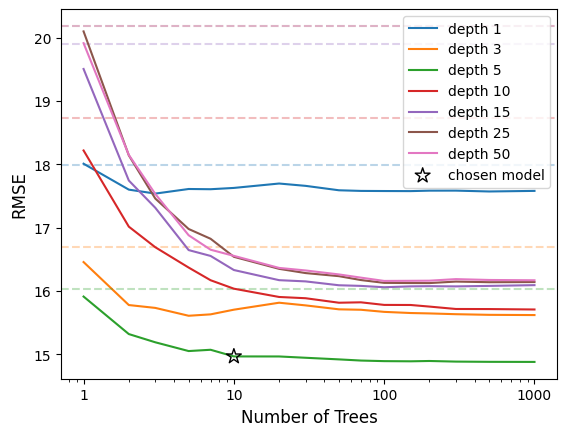

In [20]:
'''
ADD TREES ERRORS
'''

trainings_trees = pd.DataFrame(
    [[d, cvs, -1.] for d in depth for cvs in range(n_cv)],
    columns = ['depth', 'cv', 'rmse']
)

for e in tqdm(range(len(trainings_trees))):
    
    df_train = df_train_all_cv[trainings_trees['cv'][e]].copy()
    df_test  = df_test_all_cv[trainings_trees['cv'][e]].copy()

    model = DecisionTreeRegressor(
        criterion    = 'squared_error',
        max_depth    = trainings_trees['depth'][e],
        random_state = 0,
        splitter     = 'best')

    model.fit(
        df_train[input_vars].values,
        df_train[output_vars].values[:,0]
    )

    predictions = model.predict(
        df_test[input_vars].values
    )

    targets = df_test[output_vars].values[:,0]
    rmse = ((predictions - targets)**2).mean() ** 0.5
    trainings_trees.loc[e, 'rmse'] = rmse
    
    del model
    
    
# PLOT

trainings_trees_plot = trainings_trees.copy()
trainings_trees_plot = trainings_trees_plot.drop(columns=['cv'])
if cv:
    trainings_trees_plot = trainings_trees_plot.groupby(['depth']).agg({'rmse': 'mean'}).reset_index()
    
print(trainings_trees_plot)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure()
for e, d in enumerate(depth):
    plt.plot(
        trainings_cv[trainings_cv['depth'] == d]['trees'],
        trainings_cv[trainings_cv['depth'] == d]['rmse'],
        label = f'depth {d}',
        color = colors[e]
    )
    plt.axhline(
        y       = trainings_trees_plot.loc[e, 'rmse'],
        color   = colors[e],
        linestyle = '--',
        alpha   = 0.3
    )

# Highlight the chosen model
rmse = trainings_cv.query('trees == 10 and depth == 5')['rmse'].values[0]
plt.scatter(10, rmse, color='black', facecolors='none', s=125, marker = '*', label = 'chosen model', zorder=10)

plt.xscale('log')
plt.xticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
if cv:
    #plt.title('Random Forest Performance')
    plt.savefig('figures/rmse_RF_' + str(n_cv) + 'cv.png', dpi = 300)
else:
    #plt.title('Random Forest Performance')
    plt.savefig('figures/rmse_RF.png')
plt.show()

In [13]:
'''
PLOTS FOR DAYS
'''

tree = 10
depth = 5

models = []

for i, (df_train_all, df_test_all) in enumerate(zip(df_train_all_cv, df_test_all_cv)):
    df_train = df_train_all.copy()
    df_test = df_test_all.copy()

    model = RandomForestRegressor(
        n_estimators        = tree,
        min_samples_split   = 2,
        min_samples_leaf    = 1,
        max_features        = 3,
        random_state        = 314,
        max_depth = depth
    )

    model.fit(
        df_train[input_vars].values,
        df_train[output_vars].values[:,0]
    )

    if i == 0:
        print("Número de árboles:", model.n_estimators)

        for j, tr in enumerate(model.estimators_):
            print(f"Árbol {j}:")
            print(f"  Profundidad: {tr.get_depth()}")
            print(f"  Número de nodos: {tr.tree_.node_count}")
            print(f"  Número de hojas: {tr.tree_.n_leaves}")
            print(f"  Número de características: {tr.n_features_in_}")

        # Importancia de características
        importances = model.feature_importances_
        print("Importancia de las características:", importances)

    predictions = model.predict(
        df_test[input_vars].values
    )

    models.append([df_test, predictions])

    del model

Número de árboles: 10
Árbol 0:
  Profundidad: 5
  Número de nodos: 61
  Número de hojas: 31
  Número de características: 4
Árbol 1:
  Profundidad: 5
  Número de nodos: 63
  Número de hojas: 32
  Número de características: 4
Árbol 2:
  Profundidad: 5
  Número de nodos: 63
  Número de hojas: 32
  Número de características: 4
Árbol 3:
  Profundidad: 5
  Número de nodos: 63
  Número de hojas: 32
  Número de características: 4
Árbol 4:
  Profundidad: 5
  Número de nodos: 63
  Número de hojas: 32
  Número de características: 4
Árbol 5:
  Profundidad: 5
  Número de nodos: 63
  Número de hojas: 32
  Número de características: 4
Árbol 6:
  Profundidad: 5
  Número de nodos: 63
  Número de hojas: 32
  Número de características: 4
Árbol 7:
  Profundidad: 5
  Número de nodos: 63
  Número de hojas: 32
  Número de características: 4
Árbol 8:
  Profundidad: 5
  Número de nodos: 61
  Número de hojas: 31
  Número de características: 4
Árbol 9:
  Profundidad: 5
  Número de nodos: 63
  Número de hojas: 32

In [14]:
'''
Errors RF
'''

rmseA_cv = []
maeA_cv = []
# Evaluación del modelo
for model in models:
    df_test, predictions = model

    targets = df_test[output_vars].values[:,0]
    rmseA = ((predictions - targets)**2).mean() ** 0.5
    maeA = (abs(predictions - targets)).mean()

    rmseA_cv.append(rmseA)
    maeA_cv.append(maeA)

if cv:
    print(f"{tree} trees, {depth} depth, RMSE, {n_cv} cv: {np.mean(rmseA_cv)}")
    print(f"{tree} trees, {depth} depth, MAE, {n_cv} cv: {np.mean(maeA_cv)}")
    print('\n')
else:
    print(f"{tree} trees, {depth} depth, RMSE, {k} k: {rmseA_cv[0]}")
    print(f"{tree} trees, {depth} depth, MAE, {k} k: {maeA_cv[0]}")

10 trees, 5 depth, RMSE, 5 cv: 14.965028139991569
10 trees, 5 depth, MAE, 5 cv: 11.336524081133351




  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:05<00:00,  2.99it/s]
/home/local/upvnet.upv.es/ssansil/V/comun/vaques/utils/plots.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = means.groupby(pd.cut(means['time_float'], time_intervals))
/home/local/upvnet.upv.es/ssansil/V/comun/vaques/utils/plots.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_pred = mean_pred.groupby(pd.cut(mean_pred['time_float'], time_intervals)).mean()


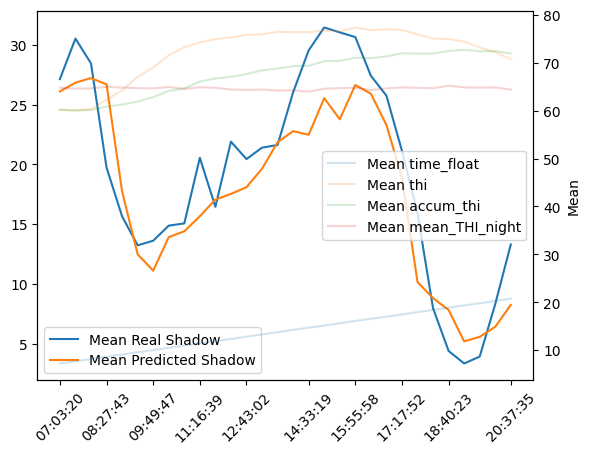

In [15]:
df_test, predictions = models[0]

save_name = f'random_forest_{tree}t_{depth}d'
 
plot_result(df_test, input_vars, predictions,
            save_name = save_name)

In [16]:
results = []
means = []

for t in tqdm(range(n_cv)):
    
    df_train = df_train_all_cv[t].copy()
    df_test  = df_test_all_cv[t].copy()

    model = RandomForestRegressor(
        n_estimators        = tree,
        min_samples_split   = 2,
        min_samples_leaf    = 1,
        max_features        = 3,
        random_state        = 314,
        max_depth           = depth
    )

    model.fit(
        df_train[input_vars].values,
        df_train[output_vars].values[:,0]
    )

    predictions = model.predict(
        df_test[input_vars].values
    )

    targets = df_test[output_vars].values[:,0]
    rmse = ((predictions - targets)**2).mean() ** 0.5
    
    print(f'CV: {t}, RMSE: {rmse}')
    
    if t == 0:
        time_intervals = pd.interval_range(
            start = df_train['time_float'].min(),
            end   = df_train['time_float'].max(),
            periods = 30
        )
    
    results_, means_ = plot_result_v2(
        df_test, input_vars, predictions,
        time_intervals,
        save_name = model_name
    )
    
    results.append(results_)
    means.append(means_)
    
all_results = pd.concat(results, ignore_index=True)
all_means = pd.concat(means, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

CV: 0, RMSE: 14.001335208557478


15it [00:07,  1.92it/s]
/home/local/upvnet.upv.es/ssansil/V/comun/vaques/utils/plots.py:198: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = means.groupby(pd.cut(means['time_float'], time_intervals))
/home/local/upvnet.upv.es/ssansil/V/comun/vaques/utils/plots.py:204: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_pred = mean_pred.groupby(pd.cut(mean_pred['time_float'], time_intervals)).mean()
 20%|██        | 1/5 [00:07<00:31,  7.89s/it]

CV: 1, RMSE: 13.985096863919038


15it [00:07,  2.00it/s]
/home/local/upvnet.upv.es/ssansil/V/comun/vaques/utils/plots.py:198: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = means.groupby(pd.cut(means['time_float'], time_intervals))
/home/local/upvnet.upv.es/ssansil/V/comun/vaques/utils/plots.py:204: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_pred = mean_pred.groupby(pd.cut(mean_pred['time_float'], time_intervals)).mean()
 40%|████      | 2/5 [00:15<00:23,  7.70s/it]

CV: 2, RMSE: 16.37703898461223


15it [00:07,  1.90it/s]
/home/local/upvnet.upv.es/ssansil/V/comun/vaques/utils/plots.py:198: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = means.groupby(pd.cut(means['time_float'], time_intervals))
/home/local/upvnet.upv.es/ssansil/V/comun/vaques/utils/plots.py:204: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_pred = mean_pred.groupby(pd.cut(mean_pred['time_float'], time_intervals)).mean()
 60%|██████    | 3/5 [00:23<00:15,  7.81s/it]

CV: 3, RMSE: 14.350884022785696


15it [00:07,  1.92it/s]
/home/local/upvnet.upv.es/ssansil/V/comun/vaques/utils/plots.py:198: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = means.groupby(pd.cut(means['time_float'], time_intervals))
/home/local/upvnet.upv.es/ssansil/V/comun/vaques/utils/plots.py:204: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_pred = mean_pred.groupby(pd.cut(mean_pred['time_float'], time_intervals)).mean()
 80%|████████  | 4/5 [00:31<00:07,  7.84s/it]

CV: 4, RMSE: 16.110785620083405


15it [00:07,  1.88it/s]
/home/local/upvnet.upv.es/ssansil/V/comun/vaques/utils/plots.py:198: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = means.groupby(pd.cut(means['time_float'], time_intervals))
/home/local/upvnet.upv.es/ssansil/V/comun/vaques/utils/plots.py:204: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_pred = mean_pred.groupby(pd.cut(mean_pred['time_float'], time_intervals)).mean()
100%|██████████| 5/5 [00:39<00:00,  7.86s/it]


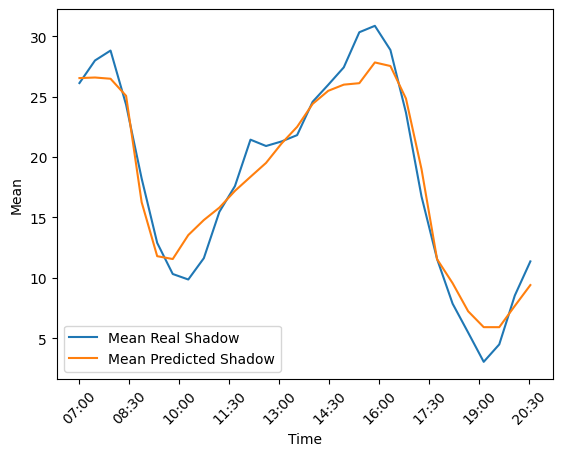

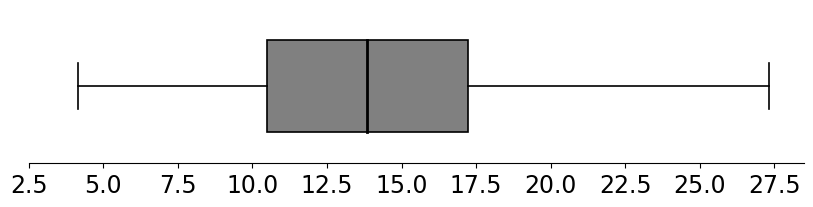

In [17]:
all_results = all_results.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
mean_df = all_means.groupby('time').mean()
plot_means(mean_df.shadow, mean_df.pred, mean_df.index, save_name = model_name)


plt.figure(figsize=(10, 2))

# Create horizontal box plot with adjusted thicker median line
plt.boxplot(all_results['RMSE'], 
            vert=False, 
            widths=0.6,  # Slightly increase the box width to accommodate the thicker median line
            patch_artist=True,  # Enables color filling
            boxprops=dict(facecolor='gray', color='black', linewidth=1.2),  # Gray box with black border
            whiskerprops=dict(color='black', linewidth=1.2),  # Thicker whiskers
            capprops=dict(color='black', linewidth=1.2),  # Thicker caps
            medianprops=dict(color='black', linewidth=2),  # Slightly reduce median line width
            flierprops=dict(marker='o', color='black', markersize=5, linewidth=2))

#plt.xlabel('RMSE')
plt.xticks(np.arange(2.5, 30, 2.5), fontsize=17)
plt.yticks([])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)

plt.savefig(f'figures/results/boxplot_random_forest_{tree}t_{depth}d.png', bbox_inches='tight', dpi = 500)
plt.show()

In [18]:
for i in [18,19,56,57]:
    print(all_results.iloc[i])

print('\n Mediana:')
print((all_results.iloc[37].RMSE + all_results.iloc[38].RMSE) /2)

date    2023-09-19
RMSE     10.442007
Name: 18, dtype: object
date    2023-08-18
RMSE      10.51555
Name: 19, dtype: object
date    2023-07-26
RMSE      17.37701
Name: 56, dtype: object
date    2023-07-20
RMSE     17.384024
Name: 57, dtype: object

 Mediana:
13.9832686882039


In [19]:
'''
PLOT DAYS
'''

days = [all_results.iloc[19].date, all_results.iloc[57].date]
print(days)

results = []
means = []

for t in tqdm(range(n_cv)):
    for d in days:
        if d in df_test_all_cv[t].date_day.unique():
            print(t)
            df_train = df_train_all_cv[t].copy()
            df_test  = df_test_all_cv[t].copy()
            df_test = df_test[df_test.date_day == d]

            model = RandomForestRegressor(
                n_estimators        = tree,
                min_samples_split   = 2,
                min_samples_leaf    = 1,
                max_features        = 3,
                random_state        = 314,
                max_depth           = depth
            )

            model.fit(
                df_train[input_vars].values,
                df_train[output_vars].values[:,0]
            )

            predictions = model.predict(
                df_test[input_vars].values
            )

            plot_result_v3(
                df_test, input_vars, predictions,
                max_cows=80, min_thi=60, max_thi=85,
                save_name = model_name + '_good'
            )

['2023-08-18', '2023-07-20']


  0%|          | 0/5 [00:00<?, ?it/s]

0


1it [00:00,  1.94it/s]
 20%|██        | 1/5 [00:00<00:02,  1.78it/s]

4


1it [00:00,  1.88it/s]
100%|██████████| 5/5 [00:01<00:00,  4.36it/s]


In [20]:
'''
INFLUENCE OF PAST DAYS
'''
    
past_days = list(range(16))
all_days = [True, False]
combinations = pd.DataFrame([[pd, ad, cvs, -1.] for pd in past_days for ad in all_days for cvs in range(n_cv)],
                            columns = ['past_days', 'all_days', 'cv', 'rmse'])

for e in tqdm(range(len(combinations))):

    df_train_past_days = df_train_all_cv[combinations['cv'][e]].copy()
    df_test_past_days  = df_test_all_cv[combinations['cv'][e]].copy()

    df_train_past_days = df_train_past_days.dropna()
    df_test_past_days = df_test_past_days.dropna()

    pd = combinations['past_days'][e]
    ad = combinations['all_days'][e]

    input_vars_act = input_vars
    if pd > 0:
        if ad:
            input_vars_act = input_vars + [f'mean_THI_days_{pd}']
        else:
            input_vars_act = input_vars + [f'mean_THI_days_{i}' for i in range(1, pd+1)]
    
    model = RandomForestRegressor(
        n_estimators        = tree,
        min_samples_split   = 2,
        min_samples_leaf    = 1,
        max_features        = 'sqrt',
        random_state        = 42,
        max_depth = depth
    )

    model.fit(
        df_train_past_days[input_vars_act].values,
        df_train_past_days[output_vars].values[:,0]
    )

    predictions = model.predict(
        df_test_past_days[input_vars_act].values
    )

    targets = df_test_past_days[output_vars].values[:,0]
    rmse = ((predictions - targets)**2).mean() ** 0.5
    combinations.loc[e, 'rmse'] = rmse
    
    del model

  6%|▋         | 10/160 [00:00<00:04, 30.01it/s]


KeyError: "['mean_THI_days_1'] not in index"

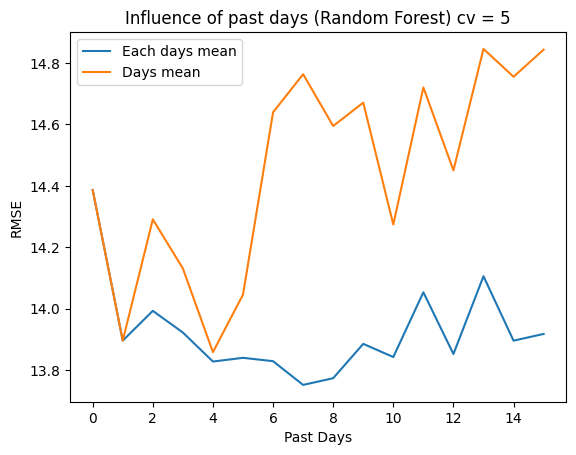

In [85]:
'''
PLOT PAST DAYS
'''

combinations_cv = combinations.copy()
combinations_cv = combinations_cv.drop(columns=['cv'])
if cv:
    combinations_cv = combinations_cv.groupby(['past_days', 'all_days']).agg({'rmse': 'mean'}).reset_index()


fig, ax = plt.subplots()

combinations_true = combinations_cv[combinations_cv['all_days'] == True]
combinations_false = combinations_cv[combinations_cv['all_days'] == False]
ax.plot(combinations_true['past_days'], combinations_true['rmse'], label = 'Each days mean')
ax.plot(combinations_false['past_days'], combinations_false['rmse'], label = 'Days mean')
ax.legend()
ax.set_xlabel('Past Days')
ax.set_ylabel('RMSE')
if cv:
    ax.set_title('Influence of past days (Random Forest) cv = ' + str(n_cv))
    plt.savefig('figures/past_days_' + str(n_cv) + 'cv.png')
else:
    ax.set_title('Influence of past days (Random Forest)')
    plt.savefig('figures/past_days.png')
plt.show()

In [49]:
'''
NEURAL NETWORK
'''

import torch
import random

from utils.datas import torch_DataLoader
from utils.nnet  import NNet
from utils.train import fit

#from config.config_nn_8 import *

model_name  = 'model_8'

input_vars  = ['time_float',
               'thi',
               'accum_thi',
               'mean_THI_night']
output_vars = ['shadow']

class nn_config:
        
    h_layers    = [1024, 1024, 1024]
    fun_act     = 'relu'
    lr          = 1e-3
    epochs      = 50
    batch_size  = 1
    checkpoints = 10
    dropout     = 0.3

In [50]:
'''
SEMILLAS PARA EL NN
'''

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [51]:
'''
TRAIN NN
'''

print(f'Train model {model_name}.')

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

for i, (df_train_all, df_test_all) in enumerate(zip(df_train_all_cv, df_test_all_cv)):
    print(i+1)
    
    df_train = df_train_all.copy()
    df_test = df_test_all.copy()

    # Standardize data
    mean = df_train[input_vars].mean()
    std  = df_train[input_vars].std()
    df_train[input_vars] = (df_train[input_vars] - mean) / std
    df_test[input_vars]  = (df_test[input_vars] - mean) / std

    train_dl = torch_DataLoader(
        X           = df_train[input_vars].values,
        Y           = df_train[output_vars].values,
        batch_size  = nn_config.batch_size,
        device      = device,
        drop_last   = True,
        shuffle     = True
    )
    test_dl = torch_DataLoader(
        X           = df_test[input_vars].values,
        Y           = df_test[output_vars].values,
        batch_size  = nn_config.batch_size,
        device      = device,
        drop_last   = False,
        shuffle     = False
    )
    print('Data loaded')

    model = NNet(
        in_dim    = len(input_vars),
        out_dim   = len(output_vars),
        h_layers  = nn_config.h_layers,
        fun_act   = nn_config.fun_act,
        dropout   = nn_config.dropout,
        device    = device,
    )
    #model.print_model()

    fit(
        model       = model,
        num_epochs  = nn_config.epochs,
        train_dl    = train_dl,
        val_dl      = test_dl,
        loss_fun    = 'MSE',
        optim_name  = 'Adam',
        lr          = nn_config.lr,
        display     = True,
        checkpoints = nn_config.checkpoints,
        model_name  = f'{model_name}_{i+1}cv',
    )

    del model

Train model model_8.
Using cuda device
1
Data loaded


Training epoch: 100%|██████████| 50/50 [10:16<00:00, 12.33s/it]


2
Data loaded


Training epoch: 100%|██████████| 50/50 [10:00<00:00, 12.02s/it]


3
Data loaded


Training epoch:  52%|█████▏    | 26/50 [05:19<04:55, 12.30s/it]


KeyboardInterrupt: 